# Introduction

### Road transport is an essential key to the mankind and the economy of every country in the world is dependent on vehicular traffic as workers commute to work, familes go on family vacations and a list of other important activities. Safety on these roads cannot be over emphasized therefore Understanding the factors that contribute to improving safety requires knowing all the factors involved in other to save lives and improve life expectancy in a larger scale. 


# Data Description

#### We have a dataset and we will try to predict are to predict how severe a road accident could be by analyzing some contributing factors.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
#import dataset
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Folium installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [15]:
from IPython.display import display
LDN_COORDINATES = (47.60,-122.33)
seattle_map = folium.Map(LDN_COORDINATES, zoom_start=11)
# display map
display(seattle_map)

In [7]:
print(df.shape)
df.columns

(194673, 38)


Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [8]:
#Interest points:
df2 = df.copy(deep = True)
df2['INCDTTM'] = pd.to_datetime(df2['INCDTTM'], errors='coerce')

In [16]:
df2['Year']=df2['INCDTTM'].dt.year
df2['Month']=df2['INCDTTM'].dt.month
df2['Day']=df2['INCDTTM'].dt.day
df2['Weekday']=df2['INCDTTM'].dt.weekday
df2['Hour'] = df2['INCDTTM'].dt.hour

In [17]:
#lets get the data of collisions due to alcohol influence from 2013 - 2020
alcohol = df2[df2['UNDERINFL'] == "Y"]
alcohol = alcohol[alcohol['Year'].isin([2013,2020])]

severity_alc1 = alcohol[alcohol['SEVERITYCODE'] == 1]
severity_alc2 = alcohol[alcohol['SEVERITYCODE'] == 2]
severity_alc1 = severity_alc1[['X',"Y"]]
severity_alc2 = severity_alc2[['X',"Y"]]

#drop null values
severity_alc1.dropna(inplace = True)
severity_alc2.dropna(inplace = True)

print(severity_alc1.count())
print(severity_alc2.count())

X    258
Y    258
dtype: int64
X    180
Y    180
dtype: int64


In [18]:
#plot data of collisions due to alcohol influence from 2013 - 2020
collision1 = folium.map.FeatureGroup()
collision2 = folium.map.FeatureGroup()
#print(speed.count())
for lat, lng, in zip(severity_alc1.Y, severity_alc1.X):
    collision1.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=0.5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

for lat, lng, in zip(severity_alc2.Y, severity_alc2.X):
    collision2.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=0.5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
seattle_map1 = folium.Map(LDN_COORDINATES, zoom_start=11)
seattle_map1.add_child(collision1)
seattle_map1.add_child(collision2)




In [19]:
#lets get the data of collisions due to over speeding from 2013 - 2020
over_speeding = df2[df['SPEEDING'] == "Y"]
over_speeding = over_speeding[over_speeding['Year'].isin([2013,2020])]

over_speeding1 = over_speeding[over_speeding['SEVERITYCODE'] == 1]
over_speeding2 = over_speeding[over_speeding['SEVERITYCODE'] == 2]
over_speeding1 = over_speeding1[['X',"Y"]]
over_speeding2 = over_speeding2[['X',"Y"]]
#drop null values
over_speeding1.dropna(inplace = True)
over_speeding2.dropna(inplace = True)
print(over_speeding1.count())
print(over_speeding2.count())

X    316
Y    316
dtype: int64
X    214
Y    214
dtype: int64


In [20]:
#plot data of collisions due to alcohol influence from 2013 - 2020
speed_collision1 = folium.map.FeatureGroup()
speed_collision2 = folium.map.FeatureGroup()
for lat, lng, in zip(over_speeding1.Y, over_speeding1.X):
    speed_collision1.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=0.5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

for lat, lng, in zip(over_speeding2.Y, over_speeding2.X):
    speed_collision2.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=0.9, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
seattle_map1 = folium.Map(LDN_COORDINATES, zoom_start=11)
seattle_map1.add_child(speed_collision1)
seattle_map1.add_child(speed_collision2)


# Data preparation and feature selection

In [14]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [38]:
X = df[['ADDRTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INCDTTM','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','COLLISIONTYPE','HITPARKEDCAR']]
X[0:5]

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,COLLISIONTYPE,HITPARKEDCAR
0,Intersection,2,0,0,2,3/27/2013 2:54:00 PM,NaN,N,Overcast,Wet,Daylight,NaN,NaN,Angles,N
1,Block,2,0,0,2,12/20/2006 6:55:00 PM,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,Sideswipe,N
2,Block,4,0,0,3,11/18/2004 10:20:00 AM,NaN,0,Overcast,Dry,Daylight,NaN,NaN,Parked Car,N
3,Block,3,0,0,3,3/29/2013 9:26:00 AM,NaN,N,Clear,Dry,Daylight,NaN,NaN,Other,N
4,Intersection,2,0,0,2,1/28/2004 8:04:00 AM,NaN,0,Raining,Wet,Daylight,NaN,NaN,Angles,N


In [39]:
X['INCDTTM'] = pd.to_datetime(X['INCDTTM'], errors='coerce')
X['Year']=X['INCDTTM'].dt.year
X['Month']=X['INCDTTM'].dt.strftime('%b')
X['Day']=X['INCDTTM'].dt.day
X['Hour']=X['INCDTTM'].dt.hour
X['Weekend']=X['INCDTTM'].dt.weekday
X.drop(['INCDTTM'],axis = 1,inplace = True)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,COLLISIONTYPE,HITPARKEDCAR,Year,Month,Day,Hour,Weekend
0,Intersection,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,NaN,Angles,N,2013,Mar,27,14,2
1,Block,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,Sideswipe,N,2006,Dec,20,18,2
2,Block,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,NaN,Parked Car,N,2004,Nov,18,10,3
3,Block,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,NaN,Other,N,2013,Mar,29,9,4
4,Intersection,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,NaN,Angles,N,2004,Jan,28,8,2


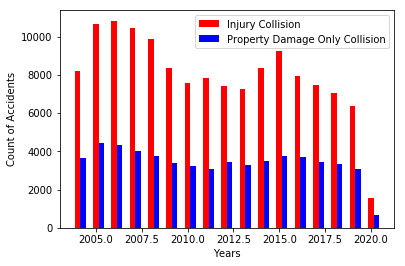

In [21]:
##Time plotting of accidents
years  = df2['Year'].unique()
width = 0.3
for year in years:
  X2 = df2[df2['Year'] == year]
  val1 = X2[X2['SEVERITYCODE'] == 1 ].shape[0]
  val2 = X2[X2['SEVERITYCODE'] == 2 ].shape[0]
  plt.bar(int(year), val1, width  = width, color = 'red')
  plt.bar(int(year) + width, val2, width  = width,color = 'blue')
plt.xlabel('Years')
plt.ylabel('Count of Accidents')
plt.legend(X2['SEVERITYDESC'].unique())
plt.show()

In [40]:
#converting column parameters to binary
X['UNDERINFL'] = X['UNDERINFL'].fillna(0)
X['UNDERINFL'].replace('Y',1,inplace =True)
X['UNDERINFL'].replace('N',0,inplace =True)
X['INATTENTIONIND'].replace('Y',1,inplace = True)
X['INATTENTIONIND'] = X['INATTENTIONIND'].fillna(0)
X['SPEEDING'].replace('Y',1,inplace =True)
X['SPEEDING'] = X['SPEEDING'].fillna(0)
X['PEDROWNOTGRNT'].replace('Y',1,inplace =True)
X['PEDROWNOTGRNT'] = X['PEDROWNOTGRNT'].fillna(0)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,COLLISIONTYPE,HITPARKEDCAR,Year,Month,Day,Hour,Weekend
0,Intersection,2,0,0,2,0.0,0,Overcast,Wet,Daylight,0.0,0.0,Angles,N,2013,Mar,27,14,2
1,Block,2,0,0,2,0.0,0,Raining,Wet,Dark - Street Lights On,0.0,0.0,Sideswipe,N,2006,Dec,20,18,2
2,Block,4,0,0,3,0.0,0,Overcast,Dry,Daylight,0.0,0.0,Parked Car,N,2004,Nov,18,10,3
3,Block,3,0,0,3,0.0,0,Clear,Dry,Daylight,0.0,0.0,Other,N,2013,Mar,29,9,4
4,Intersection,2,0,0,2,0.0,0,Raining,Wet,Daylight,0.0,0.0,Angles,N,2004,Jan,28,8,2


In [41]:
#converting more column parameters to binary
print(len(X["ROADCOND"].unique()))
X["ROADCOND"].replace(X["ROADCOND"].unique(),[i for i in range(1,1+len(X["ROADCOND"].unique()))],inplace = True)
X["ROADCOND"] = X["ROADCOND"].fillna(0)
X["WEATHER"].replace(X["WEATHER"].unique(),[i for i in range(1,1+len(X["WEATHER"].unique()))],inplace = True)
X["WEATHER"] = X["WEATHER"].fillna(0)

X["LIGHTCOND"].replace(X["LIGHTCOND"].unique(),[i for i in range(1,1+len(X["LIGHTCOND"].unique()))],inplace = True)
X["LIGHTCOND"] = X["LIGHTCOND"].fillna(0)

X["ADDRTYPE"].replace(X["ADDRTYPE"].unique(),[i for i in range(1,1+len(X["ADDRTYPE"].unique()))],inplace = True)
X["ADDRTYPE"] = X["ADDRTYPE"].fillna(0)

X["Month"].replace(X["Month"].unique(),[i for i in range(1,1+len(X["Month"].unique()))],inplace = True)
X["Month"] = X["Month"].fillna(0)
X["COLLISIONTYPE"].replace(X["COLLISIONTYPE"].unique(),[i for i in range(1,1+len(X["COLLISIONTYPE"].unique()))],inplace = True)
X["COLLISIONTYPE"] = X["COLLISIONTYPE"].fillna(0)

X["HITPARKEDCAR"].replace(X["HITPARKEDCAR"].unique(),[i for i in range(1,1+len(X["HITPARKEDCAR"].unique()))],inplace = True)
X["HITPARKEDCAR"] = X["HITPARKEDCAR"].fillna(0)

X[0:5]

10


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,COLLISIONTYPE,HITPARKEDCAR,Year,Month,Day,Hour,Weekend
0,1,2,0,0,2,0.0,0,1,1,1,0.0,0.0,1,1,2013,1,27,14,2
1,2,2,0,0,2,0.0,0,2,1,2,0.0,0.0,2,1,2006,2,20,18,2
2,2,4,0,0,3,0.0,0,1,2,1,0.0,0.0,3,1,2004,3,18,10,3
3,2,3,0,0,3,0.0,0,3,2,1,0.0,0.0,4,1,2013,1,29,9,4
4,1,2,0,0,2,0.0,0,2,1,1,0.0,0.0,1,1,2004,4,28,8,2


In [42]:
X['INATTENTIONIND'] = X['INATTENTIONIND'].astype(int)
X['SPEEDING'] = X['SPEEDING'].astype(int)
X['PEDROWNOTGRNT'] = X['PEDROWNOTGRNT'].astype(int)
X[0:10]

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,COLLISIONTYPE,HITPARKEDCAR,Year,Month,Day,Hour,Weekend
0,1,2,0,0,2,0,0,1,1,1,0,0,1,1,2013,1,27,14,2
1,2,2,0,0,2,0,0,2,1,2,0,0,2,1,2006,2,20,18,2
2,2,4,0,0,3,0,0,1,2,1,0,0,3,1,2004,3,18,10,3
3,2,3,0,0,3,0,0,3,2,1,0,0,4,1,2013,1,29,9,4
4,1,2,0,0,2,0,0,2,1,1,0,0,1,1,2004,4,28,8,2
5,1,2,0,0,2,0,0,3,2,1,0,0,1,1,2019,5,20,17,5
6,1,2,0,0,2,0,0,2,1,1,0,0,1,1,2008,2,9,0,1
7,1,3,0,1,1,0,0,3,2,1,0,0,5,1,2020,5,15,17,2
8,2,2,0,0,2,0,0,3,2,1,0,0,3,1,2006,6,15,13,3
9,1,2,0,0,2,0,0,3,2,1,0,0,1,1,2006,1,20,15,0


In [43]:
X = np.asarray(X)
X[0:5]

array([[1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2013, 1, 27, 14, 2],
       [2, 2, 0, 0, 2, 0, '0', 2, 1, 2, 0, 0, 2, 1, 2006, 2, 20, 18, 2],
       [2, 4, 0, 0, 3, 0, '0', 1, 2, 1, 0, 0, 3, 1, 2004, 3, 18, 10, 3],
       [2, 3, 0, 0, 3, 0, 0, 3, 2, 1, 0, 0, 4, 1, 2013, 1, 29, 9, 4],
       [1, 2, 0, 0, 2, 0, '0', 2, 1, 1, 0, 0, 1, 1, 2004, 4, 28, 8, 2]],
      dtype=object)

In [44]:
y = np.asarray(df['SEVERITYCODE'])
y[0:5]

array([2, 1, 1, 1, 2])

In [32]:
#import libraries for machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

LETS NORMALIZE OUR DATASET

In [45]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.30002869, -0.33020207, -0.18743029, -0.16958841,  0.12553783,
        -0.42518348, -0.2217116 , -1.58584486, -1.10230941, -0.58134346,
        -0.1567239 , -0.22440165, -1.19730563, -0.19619929,  0.39603209,
        -1.59724681,  1.29556833,  0.40039328, -0.48852801],
       [ 0.58573264, -0.33020207, -0.18743029, -0.16958841,  0.12553783,
        -0.42518348, -0.2217116 , -0.69441157, -1.10230941,  0.06212826,
        -0.1567239 , -0.22440165, -0.82313345, -0.19619929, -1.10066013,
        -1.3072869 ,  0.49941317,  0.96574202, -0.48852801],
       [ 0.58573264,  1.15576451, -0.18743029, -0.16958841,  1.7102107 ,
        -0.42518348, -0.2217116 , -1.58584486,  0.01162151, -0.58134346,
        -0.1567239 , -0.22440165, -0.44896126, -0.19619929, -1.52828648,
        -1.01732699,  0.27194027, -0.16495546,  0.03188685],
       [ 0.58573264,  0.41278122, -0.18743029, -0.16958841,  1.7102107 ,
        -0.42518348, -0.2217116 ,  0.19702172,  0.01162151, -0.58134346,
        -0.156

### Train/Test dataset

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (19467, 19) (19467,)
Test set: (175206, 19) (175206,)


# LOGISTIC REGRESSION

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
yhat = LR.predict(X_test)
yhat[0:5]

array([1, 2, 1, 1, 1])

In [49]:
print('Logistic Regression')
print("LR Accuracy: ", metrics.accuracy_score(y_test,yhat))

Logistic Regression
LR Accuracy:  0.7476227983059941


**predict_proba**  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):



In [27]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.75083335, 0.24916665],
       [0.48508879, 0.51491121],
       [0.92058056, 0.07941944],
       ...,
       [0.84647647, 0.15352353],
       [0.73422599, 0.26577401],
       [0.782442  , 0.217558  ]])

<h2 id="evaluation">Evaluation</h2>



### jaccard index

Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.



In [50]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
print('jaccard')
print(jaccard_similarity_score(y_test, yhat))
print('F1 Score')
print(f1_score(y_test, yhat, average='weighted'))

jaccard
0.7476227983059941
F1 Score
0.7033271486170829


### checking feature importance

Feature: 0, Score: -0.33106
Feature: 1, Score: 0.28552
Feature: 2, Score: 0.41503
Feature: 3, Score: 0.45958
Feature: 4, Score: 0.05494
Feature: 5, Score: 0.05351
Feature: 6, Score: 0.09338
Feature: 7, Score: -0.04495
Feature: 8, Score: -0.16803
Feature: 9, Score: -0.13719
Feature: 10, Score: 0.05461
Feature: 11, Score: 0.10628
Feature: 12, Score: 0.26117
Feature: 13, Score: -0.22900
Feature: 14, Score: 0.06171
Feature: 15, Score: 0.03336
Feature: 16, Score: 0.00637
Feature: 17, Score: -0.00175
Feature: 18, Score: -0.03378


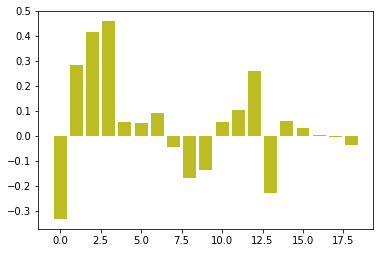

In [30]:
Feature_importance = LR.coef_[0]
for i,v in enumerate(Feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
#plot feature importance
    plt.bar([x for x in range(len(Feature_importance))], Feature_importance)
plt.show()

# svm

In [36]:
from sklearn import svm
sclf = svm.SVC(kernel='linear')
sclf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
svm_yhat = sclf.predict(X_test)
svm_yhat[0:5]

array([1, 1, 1, 1, 1])

In [40]:
print("SVM's Accuracy: ", metrics.accuracy_score(y_test, svm_yhat))
print('F1 Score')
print(f1_score(y_test,svm_yhat, average='weighted'))
print('Jaccard')
print(jaccard_similarity_score(y_test, svm_yhat))

SVM's Accuracy:  0.7503624305103707
F1 Score
0.6871015265224798
Jaccard
0.7503624305103707


# gradient booasting

In [46]:
clf = GradientBoostingClassifier(random_state=4).fit(X_train,y_train)
print('XGBoost')
GB_yhat = clf.predict(X_test)
print("XGBoost's Accuracy: ", metrics.accuracy_score(y_test,GB_yhat))
print('F1 Score')
print(f1_score(y_test,GB_yhat, average='weighted'))
print('Jaccard')
print(jaccard_similarity_score(y_test,GB_yhat))

XGBoost
XGBoost's Accuracy:  0.7581418444573816
F1 Score
0.7253349343541442
Jaccard
0.7581418444573816


[0.03221083 0.14641288 0.04978038 0.03660322 0.06002928 0.00732064
 0.03074671 0.03513909 0.04685212 0.02489019 0.01317716 0.0204978
 0.21815519 0.00878477 0.05417277 0.04245974 0.07174231 0.05124451
 0.04978038]


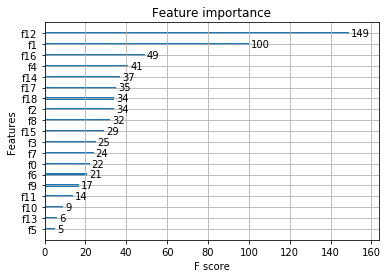

In [31]:
from xgboost import XGBClassifier
from xgboost import plot_importance
clf = XGBClassifier(random_state=4).fit(X_train,y_train)
print(clf.feature_importances_)


plot_importance(clf)

plt.show()

# random forest 

In [34]:
rf = RandomForestClassifier(max_depth=100, random_state=4).fit(X_train,y_train)
print('Random Forest')
rf_yhat = rf.predict(X_test)
print("Random Forest's Accuracy: ", metrics.accuracy_score(y_test,rf_yhat ))
print('F1 Score')
print(f1_score(y_test, rf_yhat, average='weighted'))
print('Jaccard Similarity')
print(jaccard_similarity_score(y_test, rf_yhat))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Random Forest's Accuracy:  0.7350490280013241
F1 Score
0.7127185274900378
Jaccard Similarity
0.7350490280013241
